### XGBoost classfier for Allan countability 

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xgboost as xgb

In [129]:
#load and clean data
df = pd.read_csv("../data/countabilityAnalysis_Celex.csv")
tests = ['A+N', 'F+N', 'O-Den', 'all+N']
subtypes = ['a/an', 'number', 'digits', 'plural numeral','approximative', 'comparative', 'round numbers', 'imprecise quantifier',
       'precise quantifier', 'non denumerating quantifier', 'measure', 'non quantificational', 'partitive', 'the']
bares = ["Bare Plural", "Bare Singular"]

df = df.drop(columns=["N/A", "Non-Denumerators"])
print(df.columns.values)
x_end = df.columns.values[np.where(df.columns.values == "Celex_Countable")[0][0]-1]
x_begin = df.columns.values[np.where(df.columns.values == "Noun")[0][0]+1]
print(x_begin)
print(x_end)
nouns = df["Noun"]

X = df.loc[:,x_begin:x_end]
Y = df.loc[:,"Celex_Countable":]
y1 = Y["Celex_Countable"]
y2 = Y["Celex_Uncountable"]


['Noun' 'A+N' 'F+N' 'all+N' 'O-Den' 'Bare Singular' 'Bare Plural' 'a/an'
 'number' 'digits' 'plural numeral' 'approximative' 'comparative'
 'round numbers' 'imprecise quantifier' 'precise quantifier'
 'non denumerating quantifier' 'measure' 'non quantificational'
 'partitive' 'the' 'Celex_Countable' 'Celex_Uncountable' 'Noun Count'
 'Plural Noun Percentage']
A+N
the


In [89]:
df.index[df["Noun"]=='cat'][0]

3014

In [64]:
# Normalization
scalar = MinMaxScaler()
scaled = scalar.fit_transform(X)
X.loc[:,:] = scaled

In [123]:
df.columns

Index(['Noun', 'A+N', 'F+N', 'all+N', 'O-Den', 'a/an', 'number', 'digits',
       'plural numeral', 'approximative', 'comparative', 'round numbers',
       'imprecise quantifier', 'precise quantifier',
       'non denumerating quantifier', 'measure', 'non quantificational',
       'partitive', 'the', 'Celex_Countable', 'Celex_Uncountable',
       'Noun Count', 'Plural Noun Percentage', 'Bare Singular', 'Bare Plural'],
      dtype='object')

In [65]:
seed = 7 
test_size = 0.2
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y1, random_state=seed, test_size=test_size)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y2, random_state=seed, test_size=test_size)

In [53]:
x_test1.shape

(4562, 2)

In [4]:
def get_model_data(master, drop):
    df = master.drop(columns = drop)
    x_end = df.columns.values[np.where(df.columns.values == "Celex_Countable")[0][0]-1]
    x_begin = df.columns.values[np.where(df.columns.values == "Noun")[0][0]+1]
    nouns = df["Noun"]

    X = df.loc[:,x_begin:x_end]
    Y = df.loc[:,"Celex_Countable":]
    y1 = Y["Celex_Countable"]
    y2 = Y["Celex_Uncountable"]
    
    scalar = MinMaxScaler()
    scaled = scalar.fit_transform(X)
    X.loc[:,:] = scaled
    
    data = make_model_data(X, y1, y2)
    return data

In [5]:
def make_model_data(X, y1, y2):
    data = {}
    seed = 7 
    test_size = 0.2
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y1, random_state=seed, test_size=test_size)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y2, random_state=seed, test_size=test_size)
    
    data[1] = {"x_train": x_train1, "x_test": x_test1, "y_train": y_train1, "y_test": y_test1}
    data[2] = {"x_train": x_train2, "x_test": x_test2, "y_train": y_train2, "y_test": y_test2}
    
    return data

In [6]:
def build_models(master, drops):
    models = {}
    order = tests + subtypes + bares
    for i in range(len(drops)):
        data = get_model_data(master, drops[i])
        m1 = makeModel(data[1]["x_train"], data[1]['y_train'], data[1]['x_test'], data[1]['y_test'], "countable " + str(i))
        m2 = makeModel(data[2]["x_train"], data[2]['y_train'], data[2]['x_test'], data[2]['y_test'], "uncountable "+ str(i))
        model_order = [x for x in order if x not in drops[i]]
        models[i] = (m1 , m2, model_order)
    
    return models
        

In [104]:
x = [1,2,3]
y = [1,4,5]
r = [i for i in x if i not in y]
print(r)

[2, 3]


In [7]:
def makeModel(x_train, y_train, x_test, y_test, graph_name, color = 'b', test=False, save=False):
    model = XGBRFClassifier()
    model.fit(x_train, y_train)
    
    y_predict = model.predict(x_test)
    res = [round(val) for val in y_predict]

    accuracy = accuracy_score(y_test.values, res)
    print(graph_name+" Accuracy: %.2f%% \n" % (accuracy * 100.0))
    
#     plt.rcParams.update({'font.size': 15})
#     fig = plt.figure(figsize=(15,10))
# #     print(sum(model.feature_importances_))

#     plt.barh(X.columns, model.feature_importances_, color = color)
#     plt.xlabel(graph_name+" Feature Importance", fontsize=15)
    
#     if test: name = graph_name + "_TestFeature_Importance.pdf"
#     else: name = graph_name + "_Feature_Importance.pdf"
        
#     if save: fig.savefig(name, bbox_inches='tight')
    
    return model

def plot_importances(m1, m2, order, save=False, fig_size= (7.5,5), fig_name="importances.pdf"):
    m1_gain = []
    m2_gain = []
    
    for val in order:
        m1_gain.append(m1.get_booster().get_score(importance_type = "gain").get(val,0))
        m2_gain.append(m2.get_booster().get_score(importance_type = "gain").get(val,0))
        
    x = np.arange(len(order))
    w = 0.35
    
    plt.rcParams.update({'font.size': 15})
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(fig_size)
    ax1.barh(x, m1_gain, w, color=(0.351,0.320,0.617, 1.0), tick_label=order, label='countable')
    ax1.barh(x+w, m2_gain, w, color=(0.5664,0.1093,0.2617), label = 'uncountable')
    ax1.set(xlabel='Gain')
    ax1.legend(loc=1)
    
    plt.show()
    if save: fig.savefig(fig_name, bbox_inches='tight')
    

(1.0, 2.0, 3.0)


In [166]:
def plot_all_model_importances(models, **kwargs):
    c1 = (60,15,184)
    c2 = (186,32,73)
    c1 = tuple([x/256 for x in c1])
    c2 = tuple([x/256 for x in c2])
    
    nrows = 3
    ncols = 5
    grid = GridSpec(nrows, ncols)
    plt.rcParams.update({'font.size': 17})
    fig = plt.figure(0)
    fig.set_size_inches((20,15))
    fig.clf()
    ax1 = fig.add_subplot(grid[0,0:2])
    ax2 = fig.add_subplot(grid[0,3:])
    ax3 = fig.add_subplot(grid[1:,0:2])
    ax4 = fig.add_subplot(grid[1:,3:])
    axes = [ax1,ax2,ax3,ax4]
    
    i = 0
    for ax in axes:
        m1 = models[i][0]
        m2 = models[i][1]
        order = models[i][2]
        m1_gain = []
        m2_gain = []

        for val in order:
            m1_gain.append(m1.get_booster().get_score(importance_type = "gain").get(val,0))
            m2_gain.append(m2.get_booster().get_score(importance_type = "gain").get(val,0))

        x = np.arange(len(order))
        w = 0.35
        ax.barh(x, m1_gain, w, color='silver', tick_label=order, label='countable')
        ax.barh(x+w, m2_gain, w, color='black', label = 'uncountable')
        ax.set(xlabel='Gain')
        i += 1
    
    ax1.legend(loc='upper left', bbox_to_anchor=(-0.65,1.04), fancybox=True, shadow=True)
    plt.show()
    if kwargs['save']:
        fig.savefig(kwargs['fig_name'], bbox_inches='tight')
        print("Figure saved")
        

In [66]:
# allan = False
# m1 = makeModel(x_train1, y_train1, x_test1, y_test1, "Countable", color ='c', test=allan)
# m2 = makeModel(x_train2, y_train2, x_test2, y_test2, "Uncountable", color ='pink', test=allan)


Countable Accuracy: 80.62% 

Uncountable Accuracy: 71.83% 



In [130]:
model_drops = [subtypes+bares, subtypes, tests+bares, tests]
models = build_models(df, model_drops)
    

countable 0 Accuracy: 73.26% 

uncountable 0 Accuracy: 66.11% 

countable 1 Accuracy: 81.17% 

uncountable 1 Accuracy: 73.45% 

countable 2 Accuracy: 73.24% 

uncountable 2 Accuracy: 68.72% 

countable 3 Accuracy: 81.24% 

uncountable 3 Accuracy: 73.91% 



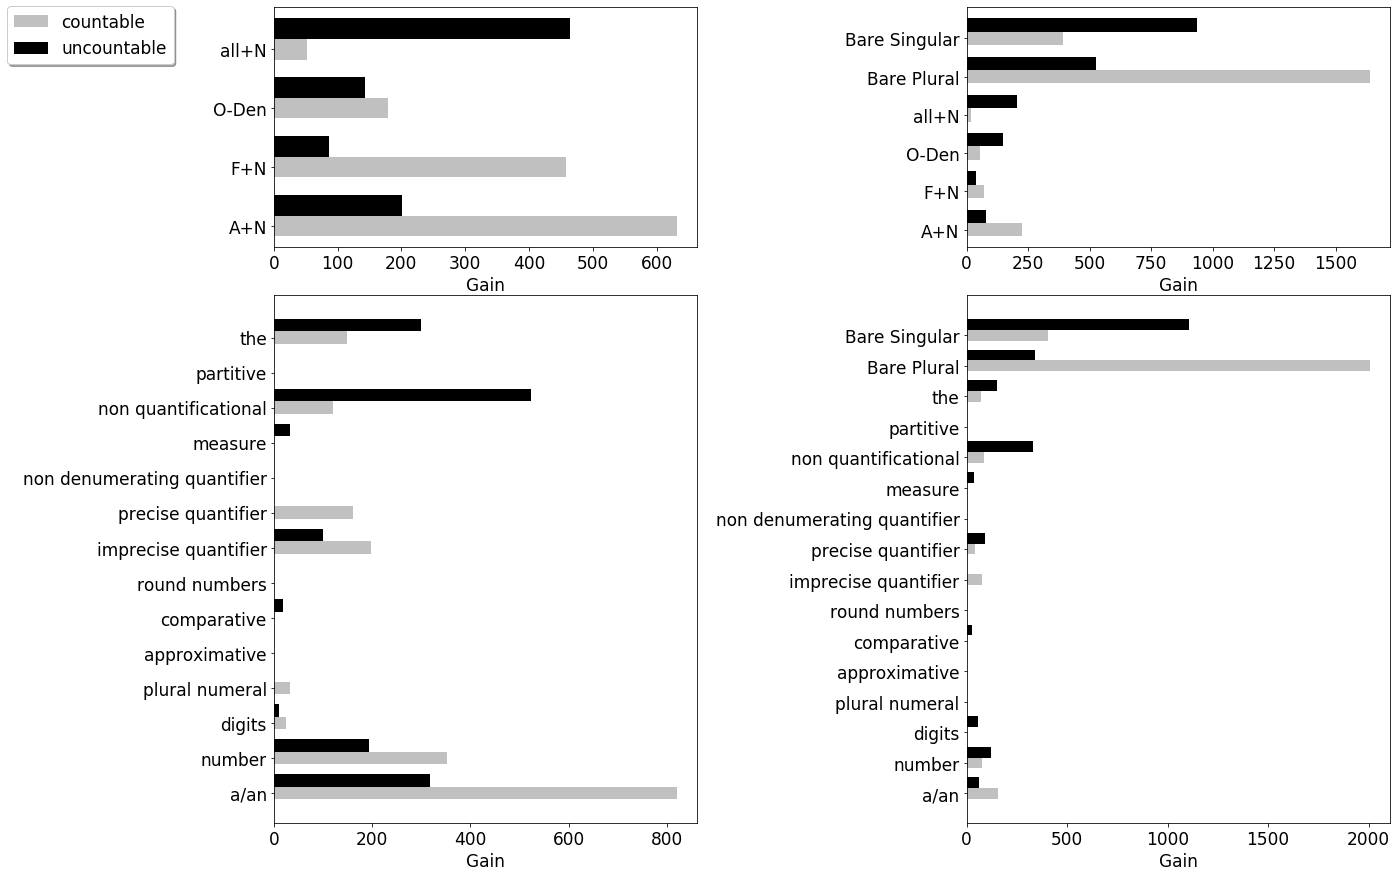

Figure saved


In [167]:
plot_all_model_importances(models, save=True, fig_name="grey_importance_graph.pdf")

In [78]:
# fig, ax = plt.subplots(figsize=(12,12))
# xgb.plot_importance(m2,importance_type="gain", max_num_features=50, height=0.8, ax=ax)
# plt.show()

list(m2.get_booster().get_score(importance_type='cover').values())


[2485.0729166666665, 1620.134980988593, 1066.593487394958, 1046.5227272727273]